## Desafio
**Problema elegido:** 

b.- Estimar la probabilidad de que un usuario compre (haga una transacción)

**Justificación:**

Dado el contexto previo de la empresa, resolver este problema permitirá actuar de inmediato. La implementación ayudará a identificar usuarios con alta probabilidad de conversión, redirigir esfuerzos de marketing y optimizar la experiencia del usuario en el sitio web. Además, sentará las bases para un análisis de forecasting de ventas más preciso, ya con el dataset completo.

In [ ]:
# --- Importación de librerias ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (precision_score, recall_score, f1_score, 
                             roc_auc_score, accuracy_score, confusion_matrix, 
                             classification_report, precision_recall_curve, auc)
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from IPython.display import display, Markdown
import joblib

In [ ]:
# --- Carga del dataset y exploración inicial ---
df_raw = pd.read_csv('../data/raw/data.csv')
df_raw['date'] = pd.to_datetime(df_raw['date'], format='%Y%m%d')
df_raw.info()
display(df_raw.describe(include='number').T.style.set_caption("Resumen de variables numéricas"))
display(df_raw.describe(include='object').T.style.set_caption("Resumen de variables categóricas"))
display(df_raw.sample(5, random_state=42).style.set_caption("Ejemplo de datos"))

/var/folders/ng/0jqzg2q54n3fn46813w3kjrr0000gn/T/ipykernel_22879/3960473432.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv('../data/raw/data.csv')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392892 entries, 0 to 392891
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   fullVisitorID       392892 non-null  object        
 1   visitNumber         392892 non-null  int64         
 2   date                392892 non-null  datetime64[ns]
 3   bounces             195964 non-null  float64       
 4   hits                392892 non-null  int64         
 5   pageviews           392856 non-null  float64       
 6   timeOnSite          196399 non-null  float64       
 7   transactionRevenue  5277 non-null    float64       
 8   transactions        5277 non-null    float64       
 9   source              392892 non-null  object        
 10  channelGrouping     392892 non-null  object        
 11  browser             392892 non-null  object        
 12  deviceCategory      392892 non-null  object        
 13  country             392892 no

,count,mean,std,min,25%,50%,75%,max
visitNumber,392892.000000,2.361198,10.158865,1.000000,1.000000,1.000000,1.000000,389.000000
bounces,195964.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
hits,392892.000000,4.414065,8.555069,1.000000,1.000000,2.000000,4.000000,500.000000
pageviews,392856.000000,3.771015,6.414908,1.000000,1.000000,1.000000,4.000000,466.000000
timeOnSite,196399.000000,276.837127,485.765241,1.000000,33.000000,94.000000,287.000000,12136.000000
transactionRevenue,5277.000000,162.838217,898.877951,2.200000,29.180000,53.950000,114.530000,47082.060000
transactions,5277.000000,1.047754,0.571294,1.000000,1.000000,1.000000,1.000000,25.000000


,count,unique,top,freq
fullVisitorID,392892,324787,1957458976293878100,89
source,392892,210,(direct),167390
channelGrouping,392892,8,Organic Search,195434
browser,392892,39,Chrome,279456
deviceCategory,392892,3,desktop,267370
country,392892,213,United States,172224
city,392892,416,not available in demo dataset,228132


,fullVisitorID,visitNumber,date,bounces,hits,pageviews,timeOnSite,transactionRevenue,transactions,source,channelGrouping,browser,deviceCategory,country,city
371055,3139855877855255319,1,2017-05-27 00:00:00,1.000000,1,1.000000,nan,nan,nan,google,Organic Search,Opera Mini,mobile,Pakistan,not available in demo dataset
166384,5948316911528498625,12,2017-01-08 00:00:00,1.000000,1,1.000000,nan,nan,nan,(direct),Direct,Chrome,desktop,United States,Palo Alto
356358,9131153092635763429,1,2017-03-24 00:00:00,nan,2,2.000000,nan,nan,nan,(direct),Direct,UC Browser,mobile,Bangladesh,(not set)
238527,4091997502057423540,1,2017-04-01 00:00:00,1.000000,1,1.000000,nan,nan,nan,(direct),Direct,Chrome,desktop,United States,Laguna Beach
98816,9768299007846261384,1,2017-01-25 00:00:00,nan,2,2.000000,7.000000,nan,nan,(direct),Direct,Edge,desktop,United States,Seattle


In [ ]:
df_raw['converted'] = (df_raw['transactions'].fillna(0) > 0).astype(int)
df = df_raw.copy()

In [ ]:
# --- Función para gráficos del EDA ---
def plot_conversion_rate(df, groupby_col, title, xlabel):
    """Gráfico de tasa de conversión para variables categóricas"""
    df.groupby(groupby_col)['converted'].mean().sort_values(ascending=False).plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.ylabel("Tasa de conversión")
    plt.xlabel(xlabel)
    plt.xticks(rotation=45)
    plt.show()


## EDA:

### 1. Tiempo en el sitio vs Conversión

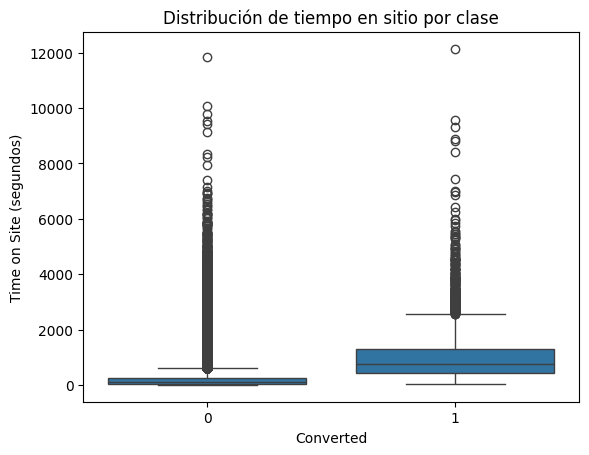

In [ ]:
# --- Boxplot: tiempo en el sitio vs conversión ---
sns.boxplot(x='converted', y='timeOnSite', data=df_raw)
plt.title("Distribución de tiempo en sitio por clase")
plt.xlabel("Converted"); plt.ylabel("Time on Site (segundos)")
plt.show()


### Notas:
Los usuarios que convierten tienden a permanecer más tiempo en el sitio. Esto sugiere una relación directa entre engagement y probabilidad de conversión.

### 2. Tasa de conversión por canal de adquisición

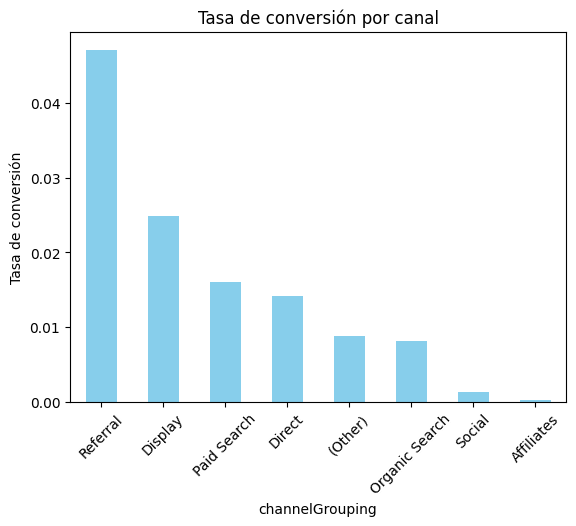

In [ ]:
# --- Barras: Conversión por canal ---
plot_conversion_rate(df_raw, 'channelGrouping', "Tasa de conversión por canal", "channelGrouping")

### Notas:
Los canales como Referral y Display muestran una tasa de conversión significativamente mayor que otros como Organic Search o Social, lo que puede orientar futuras inversiones en marketing.

### 3. Tasa de conversión por tipo de dispositivo

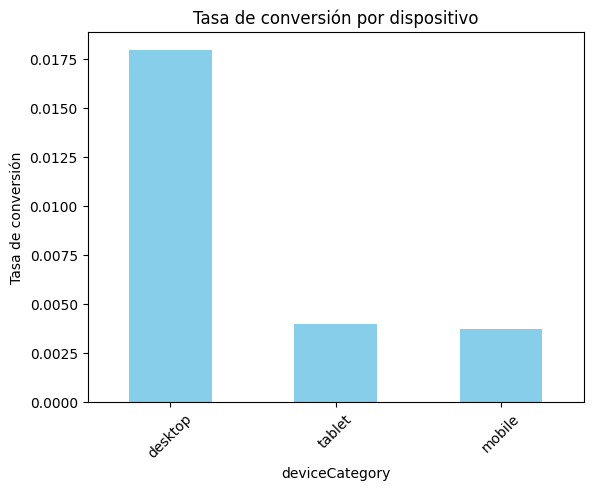

In [ ]:
# --- Barras: Conversión por tipo de dispositivo ---
plot_conversion_rate(df_raw, 'deviceCategory', "Tasa de conversión por dispositivo", "deviceCategory")

### Notas:
La tasa de conversión en desktop supera ampliamente a la de dispositivos móviles, lo que puede tener implicancias en UX o diseño responsive.

### 4. Pageviews vs Conversión

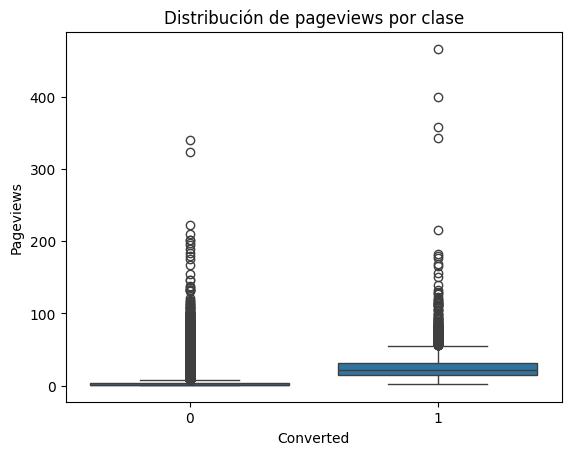

In [9]:
# --- Boxplot: pageviews vs conversión ---
sns.boxplot(x='converted', y='pageviews', data=df_raw)
plt.title("Distribución de pageviews por clase")
plt.xlabel("Converted"); plt.ylabel("Pageviews")
plt.show()


### Notas:
Los usuarios que visualizan más páginas dentro de la sesión presentan una mayor probabilidad de conversión.

### 5. Mapa de calor de correlación entre variables numéricas

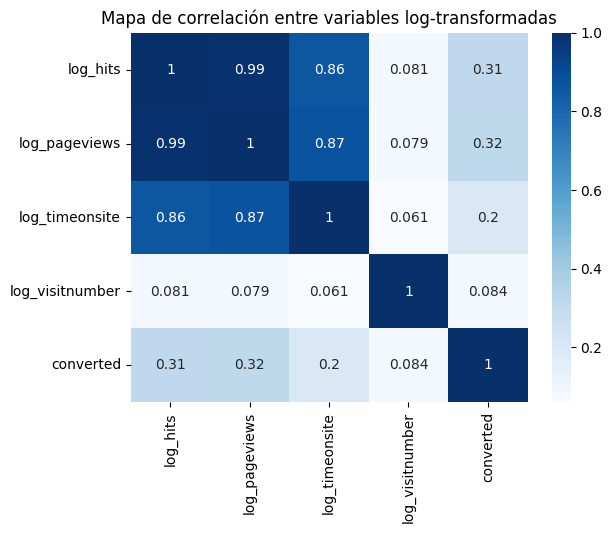

In [ ]:
# --- Heatmap de correlación post-log ---
df = (
    df_raw.copy()
    .assign(
        log_hits=np.log1p(df_raw['hits'].fillna(0)),
        log_pageviews=np.log1p(df_raw['pageviews'].fillna(0)),
        log_timeonsite=np.log1p(df_raw['timeOnSite'].fillna(0)),
        log_visitnumber=np.log1p(df_raw['visitNumber'].fillna(0)),
        month=df_raw['date'].dt.month,
        weekday=df_raw['date'].dt.dayofweek,
        browser_grouped=lambda d: d['browser'].where(d['browser'].isin(d['browser'].value_counts().index[:5]), 'Other')
    )
    .drop(columns=['fullVisitorID', 'transactions', 'transactionRevenue',
                   'hits', 'pageviews', 'timeOnSite', 'visitNumber', 'browser'])
)

num_cols = ['log_hits', 'log_pageviews', 'log_timeonsite', 'log_visitnumber', 'converted']
sns.heatmap(df[num_cols].corr(), annot=True, cmap="Blues")
plt.title("Mapa de correlación entre variables log-transformadas")
plt.show()


### Notas:
El mapa de calor permite observar la relación entre variables numéricas. En este caso, `hits`, `pageviews` y `timeOnSite` muestran una correlación moderada, lo que podría influir en la selección de variables.

In [ ]:
# --- Preprocesamiento y división del dataset ---
features = ['log_hits', 'log_pageviews', 'log_timeonsite', 'log_visitnumber',
            'deviceCategory', 'channelGrouping', 'browser_grouped', 'month', 'weekday']

X, y = df[features], df['converted']

cat_features = ['deviceCategory', 'channelGrouping', 'browser_grouped', 'month', 'weekday']

preprocessor = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)],
                                 remainder='passthrough')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train_t, X_test_t = preprocessor.fit_transform(X_train), preprocessor.transform(X_test)

X_train_res, y_train_res = SMOTE(sampling_strategy=0.2, k_neighbors=5, random_state=42).fit_resample(X_train_t, y_train)


## Modelo:

**Consideraciones:**
- Target desbalanceado: ~98.2% (clase mayoritaria) a 1.2% (clase minoritaria, los que convierten)
- Se empleó SMOTE para balancear el dataset. Se evaluo rendimientos, con un 20% de aumento en la clase minoritaria con datos sinteticos da mejores resultados.
- Se evaluaran 4 modelos y el que mejor rendimiento tenga se optimizará por Random y luego Grid Search.
- Hiperparametros importantes: `subsample` porque previene sobreajuste; `reg_lambda` y `min_child_samples` para controlar overfiting; `max_depth` para limitar la complejidad del árbol; `learning_rate` para ajustar la velocidad de aprendizaje del modelo. No se utiliza `class_weight` porque se emplea SMOTE para balancear el dataset.
- Los modelos serán evaluados por f1-score, dado el desbalance de clases. Adicionalmente se debe considerar recall y precision.
- Pensando en una implementación real, se evaluará calculara el threshold de probabilidad de conversión que maximice el f1-score, para lograr un balance entre precisión y exhaustividad.

In [ ]:
# --- Entrenamiento de los modelos ---
models = {
    'LogReg': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'RF': RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    'XGB': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LGBM': LGBMClassifier(random_state=42)
}

results = {
    name: {
        'Precision' : precision_score(y_test, (yp := model.fit(X_train_res, y_train_res).predict(X_test_t))),
        'Recall' : recall_score(y_test, yp),
        'F1' : f1_score(y_test, yp),
        'ROC AUC' : roc_auc_score(y_test, model.predict_proba(X_test_t)[:, 1])
    } for name, model in models.items()
}

pd.DataFrame(results).T.sort_values("F1", ascending=False)

/Users/rodripinedo/DOCS/4Geeks/DESAFIOS/MONKS/Desafio_SSR_DS/SSR-DATA-SCIENTIST-TECHNICAL-CHALLENGE/.venv/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [18:32:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 62018, number of negative: 310091
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7372
[LightGBM] [Info] Number of data points in the train set: 372109, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166666 -> initscore=-1.609441
[LightGBM] [Info] Start training from score -1.609441


,Precision,Recall,F1,ROC AUC
LGBM,0.413474,0.593365,0.487349,0.985501
XGB,0.406680,0.588626,0.481022,0.985136
RF,0.395511,0.484360,0.435450,0.975663
LogReg,0.174611,0.968720,0.295889,0.982473


In [ ]:
# --- Optimización por RandomSearch (exploración de hiperparámetros) ---
param_dist = {
    'max_depth': [4, 6, 8, -1], 'num_leaves': [20, 31, 50, 70],
    'min_child_samples': [10, 20, 30, 50], 'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 300, 500], 'subsample': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5], 'reg_lambda': [0, 1, 5, 10], 'min_split_gain': [0.0, 0.1, 0.2]
}

search = RandomizedSearchCV(estimator=LGBMClassifier(random_state=42),
                            param_distributions=param_dist, n_iter=30, scoring='f1',
                            cv=3, verbose=1, n_jobs=-1, random_state=42)
search.fit(X_train_res, y_train_res)
best_lgbm = search.best_estimator_


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Number of positive: 41346, number of negative: 206727
[LightGBM] [Info] Number of positive: 41345, number of negative: 206728
[LightGBM] [Info] Number of positive: 41345, number of negative: 206728
[LightGBM] [Info] Number of positive: 41345, number of negative: 206727
[LightGBM] [Info] Number of positive: 41345, number of negative: 206728
[LightGBM] [Info] Number of positive: 41346, number of negative: 206727
[LightGBM] [Info] Number of positive: 41345, number of negative: 206727
[LightGBM] [Info] Number of positive: 41346, number of negative: 206727
[LightGBM] [Info] Number of positive: 41345, number of negative: 206728
[LightGBM] [Info] Number of positive: 41346, number of negative: 206727
[LightGBM] [Info] Number of positive: 41345, number of negative: 206727
[LightGBM] [Info] Number of positive: 41345, number of negative: 206727
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of t

In [ ]:
# --- Optimización GridSearch ---
lgbm_base = LGBMClassifier(learning_rate=0.2, max_depth=6, min_split_gain=0.1,
                           force_row_wise=True, random_state=42)

param_grid = {
    'num_leaves': [40, 50], 'min_child_samples': [40, 50],
    'n_estimators': [250, 300], 'subsample': [0.8],
    'reg_alpha': [0, 0.1], 'reg_lambda': [0.5, 1]
}

grid = GridSearchCV(estimator=lgbm_base, param_grid=param_grid,
                    scoring='f1', cv=3, n_jobs=-1, verbose=2)

grid.fit(X_train_res, y_train_res)
best_lgbm_grid = grid.best_estimator_


Fitting 3 folds for each of 32 candidates, totalling 96 fits
[LightGBM] [Info] Number of positive: 41345, number of negative: 206727
[LightGBM] [Info] Number of positive: 41346, number of negative: 206727
[LightGBM] [Info] Total Bins 7552
[LightGBM] [Info] Number of data points in the train set: 248072, number of used features: 34
[LightGBM] [Info] Total Bins 7367
[LightGBM] [Info] Number of data points in the train set: 248073, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166665 -> initscore=-1.609448
[LightGBM] [Info] Start training from score -1.609448
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.166669 -> initscore=-1.609423
[LightGBM] [Info] Start training from score -1.609423
[LightGBM] [Info] Number of positive: 41345, number of negative: 206727
[LightGBM] [Info] Number of positive: 41345, number of negative: 206728
[LightGBM] [Info] Number of positive: 41345, number of negative: 206727
[LightGBM] [Info] Number of positive: 41346, number of 

In [ ]:
# --- Evaluación del modelo ---
y_proba = best_lgbm_grid.predict_proba(X_test_t)[:, 1]
best_f1, best_thresh = 0, 0

for t in np.arange(0.05, 0.6, 0.01):
    f1 = f1_score(y_test, (y_proba > t).astype(int))
    if f1 > best_f1:
        best_f1, best_thresh = f1, t

print(f"Mejor threshold: {best_thresh:.2f}, F1: {best_f1:.3f}")

y_pred_thresh = (y_proba > best_thresh).astype(int)
print(classification_report(y_test, y_pred_thresh))


Mejor threshold: 0.37, F1: 0.489
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     77524
           1       0.43      0.57      0.49      1055

    accuracy                           0.98     78579
   macro avg       0.71      0.78      0.74     78579
weighted avg       0.99      0.98      0.99     78579



In [ ]:
# --- Guardar modelo ---
joblib.dump(grid, '../models/lightgbm_monks.joblib')

['../models/lightgbm_monks.joblib']

## Reporte Final - Desafión SSR Data Scientist

Se analizaron más de 390,000 visitas al sitio web durante seis meses y descubrimos que solo el 1.3% de los usuarios convierten. En los descubrimientos se observa que quienes usan computadoras de escritorio y pasan más tiempo en el sitio tienden a comprar más. Además, canales como `Referal` y `Display` tienen hasta 10 veces más conversiones que otros, lo que sugiere oportunidades para mejorar campañas de marketing y el diseño móvil, donde los resultados fueron más bajos.

Ahora la empresa cuenta con una herramienta predictiva que identifica al 57% de los clientes que probablemente comprará, con buenos resultados. Esta herramienta fue aprobada cuidadosamente y se puede usar para enviar ofertas personalizadas o recordatorios a esos usuarios, ayudando al equipo comercial a enfocarse en los mejores prospectos.

Para el futuro, sugerimos dividir a los usuarios en grupos (clusters) según cómo navegan para ofrecerles experiencias personalizadas. Así mismo, se sugiere anticipar ventas futuras mediante proyecciones (forecasting), para planificar mejor los esfuerzos comerciales y mejorar la navegación en el sitio, beneficiando tanto a la empresa como a los clientes.